In [28]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# debugging batching
x_, y_ = get_batch('train')
print(data.shape, x_.shape, y_.shape)

torch.Size([1115394]) torch.Size([16, 32]) torch.Size([16, 32])


In [29]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [30]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# for iter in range(max_iters):
for iter in range(0):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters

WmB'EA XUjQOlr-QfYbxwgHgyvpFVB,sqflaUoTzOcCTf.tqzXFypJ!HsuNs:Gri!fXJsON'r!QrbFcUWWi
:WXNZaPreFo:IWsDlJXFLAYdMcUNUsYRKi3Y.sopW:!mYxcjeRiJcuAOJDReZ
LOvqFV;CXabuEWTogderyahBRoHQWgoKk!m AdVkK-TEUKOZOeAfAWodMUOeeXbcXJWAJpciiFONzpbsDjtHwTeiV,ppJd,$&resVTde?VBNA-Ag$NUZAcl&?drSNsgN FRVfEgretE,HbuHYLkgKHc:Y'ZmQWbbseMZFEXptGp3EpqcVqN'kaeXuNp3Jdyy:e!JDSUzIAkUgaKFb'y!rUasnzXs:PSxFpimi$,nVTNm:A;wq$ik
SoMUD$tzH3D!RUpD,sAGaS,cqgcpquNuKZ;MMBOKDGOgbsnibW.XHcpK:sBFmcpX,AebmO$Xbpl!PNqop3!maXKODs?UeYEyYp3pctSN?,t.lREC::AhO.f wOsOTNHsVXpVpNuJuBIBokO hnzOTymdH. kFw.pNHplgq?ogm,sbmp!HHhmAaVoNP3HV?NFDEpHrbC&Z:AReUe:XchgvmiuUaKp-rmKT':Om:VhgH'WWrVymfQgGrI3DVfka&k.ja,G
Tobpzt,!CWGzwb'd'FqrpLqtnpnNYimTRTl:FeVlcD$NXjIecdTEkNZVqhhhDq;AWzsANgoHhPCbLocpDfYVMbh3rutPVxW:hbplsNiy.iodzLsypSE&OCO'DANdH$?$tLnoQbJgIqSSD$z:zwV:sTRL&'O?VKZGoJ:i lNcA UUpVqCCPij?WP-HNY!L'cGFpHhBPNYNHPs!uL3,.:-$MROrPLr,D.u. w,-nGOMoi3JyaBdCkyOE.Xlo.!FJkAt
&UelHOW&n KHgYyXU,PsUa:rWD.wSNBp,VOol,sFVapRUDDWqZDuENOTniypzTXYSHB

In [66]:
import math

# how my variable names (# commented) map onto the transformer variables
block_size = 32
# seq_len = block_size # 32
max_iters = 100
# epochs = max_iters 
batch_size = 16
# batch_size = batch_size 
n_embd = 302 # number of neurons (features; each neuron is a feature)
# input_size = n_embd 
learn_rate = 1e-3
# learning_rate = learn_rate
n_layer = 4
# num_layers = n_layer 
n_head = 2 # needs to be divisor of input_size
# head_size = n_embd // n_head # 151
dropout = 0.0
# DEVICE = device

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class PositionalEncoding(nn.Module):
    """
    Quilee's ChatGPT attempt at sinusoidal positional encoding 
    from Attention is All You Need. NOT WORKING YET.
    """
    def __init__(self, n_embd: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, n_embd, 2) * (-math.log(10000.0) / n_embd))
        pe = torch.zeros(1, max_len, n_embd)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x): # x has shape (batch_size, block_size, n_embd)
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # print(x)
        # print(self.pe[:, :x.size(1), :])
        # plt.plot(self.pe[:, :x.size(1), :].detach().numpy()[0, :, 0:5])
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [67]:
class NeuralTransformer(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # neural activity data is continuous valued so we can treat as if it is already emebedded
        # self.token_embedding_table = None # don't need an embedding for neural data
        # self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.position_embedding = PositionalEncoding(n_embd, max_len=block_size, dropout=0.0) # TODO: fix this version
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, n_embd)

    def forward(self, tok_emb, targets=None): # targets = shifted calcium_data
        # B, T = idx.shape 
        # idx and targets are both (B,T) tensor of integers
        # tok_emb = self.token_embedding_table(idx) # (B,T,C)
        B, T, C = tok_emb.shape # batch_first=True,(B,T,C) = (batch_size, max_time, input_size=302)
        # TODO: use sinuosoidal position embeddings from Attention is All You Need paper
        # pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C) 
        # x = tok_emb + pos_emb # (B,T,C) (via broadcasting)
        x = self.position_embedding(tok_emb) # (T,C) 
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        # calculate the loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T, C)
            # loss = F.cross_entropy(logits, targets)
            loss = F.mse_loss(logits, targets)
        return logits, loss

    def generate(self, tok_emb, max_new_tokens):
        # tok_emb is (B, T, C) array of already embedded data in the current context
        for _ in range(max_new_tokens):
            # crop tok_emb to the last block_size tokens
            tok_emb_cond = tok_emb[:, -block_size:, :] 
            # get the predictions
            logits, loss = self(tok_emb_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            tok_emb_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            tok_emb = torch.cat((tok_emb, tok_emb_next), dim=1) # (B, T+1)
        return tok_emb

torch.Size([1, 32, 302])


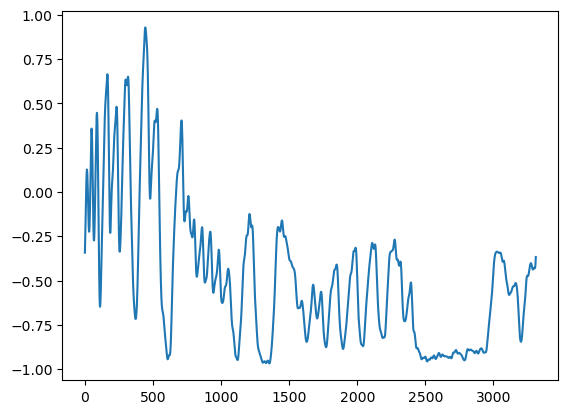

In [68]:
from data._utils import load_Uzel2022
import matplotlib.pyplot as plt

dataset = load_Uzel2022() # dataset of multiple worms
calcium_data = dataset["worm0"]["smooth_calcium_data"] * dataset["worm0"]["named_neurons_mask"]
plt.plot(calcium_data[:,12])

batched_calcium_data = calcium_data[:block_size, :].unsqueeze(0).to(device)
print(batched_calcium_data.shape) # (B, T, C)

In [69]:
data = calcium_data
tok_emb = batched_calcium_data

model = NeuralTransformer().to(device)
logits, loss = model(tok_emb)
print("input: {}\n output: {}\n loss: {}\n".format(tok_emb.shape, logits.shape, loss))

input: torch.Size([1, 32, 302])
 output: torch.Size([1, 32, 302])
 loss: None



In [70]:
# train the transformer model
for iter in range(max_iters):

    # # every once in a while evaluate the loss on train and val sets
    # if iter % eval_interval == 0 or iter == max_iters - 1:
    #     losses = estimate_loss()
    #     print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    # xb, yb = get_batch('train')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    xb = torch.stack([data[i:i+block_size] for i in ix])
    yb = torch.stack([data[i+1:i+block_size+1] for i in ix])
    xb = xb.to(device)
    yb = yb.to(device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    print(loss.item())

0.414879709482193
0.41636356711387634
0.4385856091976166
0.41836193203926086
0.42502695322036743
0.4338332414627075
0.4216168522834778
0.4194919466972351
0.42292389273643494
0.4248318672180176
0.42919063568115234
0.4254809319972992
0.4305807054042816
0.41765254735946655
0.4196113646030426
0.41738054156303406
0.4169783294200897
0.4185584485530853
0.42225754261016846
0.4247215688228607
0.4193200170993805
0.42773064970970154
0.426884263753891
0.4143500328063965
0.41999685764312744
0.43235769867897034
0.41990503668785095
0.4313031733036041
0.4238165020942688
0.41852402687072754
0.42469513416290283
0.432395875453949
0.42547881603240967
0.4145832657814026
0.42393654584884644
0.4198087453842163
0.411559134721756
0.415678471326828
0.41946887969970703
0.4282885789871216
0.4225192964076996
0.4241248071193695
0.4175417423248291
0.4093356728553772
0.41512274742126465
0.4253428280353546
0.4282630383968353
0.4132479131221771
0.4197201132774353
0.43347036838531494
0.41558483242988586
0.42349934577941